In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

from util import format_util
from matplotlib import ticker
from functools import partial

In [131]:
# import experiments from tensorboard.dev
experiment_id = 'e2nDLkjaSqKJ4yAsRvuWsQ'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_all = experiment.get_scalars()

faulty_runs = [  # these runs got stuck in a local maximum early on
    'a_ppo_door_mutex_env-inhib_300K_5V45C9BI_1',
    'a_ppo_speedup_mutex_learned-b-reward_300K_9JN24ZHH_1',
    'a_ppo_speedup_mutex_env-inhib_300K_B7RSN8EB_1',
]

In [132]:
# map to pivot tables, rename columns and drop unused columns
def to_pivot(df):
    df_pivot = df.pivot(index=['run', 'step'], columns='tag', values='value')
    df_pivot = df_pivot.reset_index()
    # df_pivot = df_pivot.loc[:, 'run':'time/fps'].drop(columns=['time/fps'])
    return df_pivot
dfp_all = to_pivot(df_all)

tag_name_map = {
    'performance/a_rew_collect_step': 'collected_all_rewards__a',
    'performance/b_rew_collect_step': 'collected_all_rewards_b',
    'performance/door_open_step': 'door_open_step',
    'performance/ep_touches': 'touches',
    'performance/ep_b_speed_active_mean': 'b_speed',
    'performance/ep_b_speed_mean': None,
    'rollout/ep_rew_mean_a': 'a_reward',
    'rollout/ep_rew_mean_b': 'b_reward',
    'rollout/ep_len_mean': None,
    'rollout/ep_rew_mean': None,
    'time/fps': None,
    'train/approx_kl': None,
    'train/clip_fraction': None,
    'train/clip_range': None,
    'train/entropy_loss': None,
    'train/explained_variance': None,
    'train/learning_rate': None,
    'train/loss': None,
    'train/policy_gradient_loss': None,
    'train/value_loss': None,
    'tag': None,
}

# rename columns, and drop unused columns
for col in dfp_all.columns:
    if col not in tag_name_map: continue
    new_col = tag_name_map.get(col)
    if new_col is None:
        dfp_all = dfp_all.drop(col, axis=1)
    else:
       dfp_all = dfp_all.rename(columns={col: new_col})

# drop faulty runs
dfp_all = dfp_all[~dfp_all['run'].isin(faulty_runs)]

In [298]:
_inhib_str_map = {
    'none': ('None', 'none'),
    'known-b-reward-0-25':  ('A: Add B\'s reward x0.25', 'add_b_rew_0.25'),
    'known-b-reward-0-75':  ('A: Add B\'s reward x0.75', 'add_b_rew_0.75'),
    'known-b-reward-1-00':  ('A: Add B\'s reward x1.00', 'add_b_rew_1.00'),
    'known-b-reward-2-00':  ('A: Add B\'s reward x2.00', 'add_b_rew_2.00'),
    'env-inhib':            ('B: Env based inhibition', 'env_inhib'),
    'env-inhib-35':            ('B: Env based inhibition', 'env_inhib_35'),  # drop from dataset
    'env-inhib-40':            ('B: Env based inhibition', 'env_inhib'),  # default env inhib in speedup env
    'learned-b-reward':     ('C: Learn B\'s reward', 'learn_b_reward'),
}

def run_to_inhibition_approach(run: str, long: bool = True):
    # a_ppo_door_mutex_env-inhib_300K_4IQLW9S8_1
    # a_ppo_door_mutex_none_300K_ZC0NV11N_1
    inhib = run.split('_')[4]
    assert inhib in _inhib_str_map, f'Unknown inhibition approach: {inhib}'
    # if 'speedup_mutex_known-b-reward' in run:
    #     print(inhib, run)
    return _inhib_str_map[inhib][0 if long else 1]

colour_map = {
    'None': (0.1, 0.1, 0.1),  # grey
    'A: Add B\'s reward x0.25': (1.0, 0.48627450980392156, 0.0),  # orange
    'A: Add B\'s reward x0.75': (1.0, 0.48627450980392156, 0.0),  # orange
    # 'A: Add B\'s reward x0.75': (0.9098039215686274, 0.0, 0.043137254901960784),  # red
    'A: Add B\'s reward x1.00': (0.10196078431372549, 0.788235294117647, 0.2196078431372549),  # green
    'A: Add B\'s reward x2.00': (0.9098039215686274, 0.0, 0.043137254901960784),  # red
    'B: Env based inhibition': (0.00784313725490196, 0.24313725490196078, 1.0),  # blue
    'B: Env based inhibition (+35)': (0.9098039215686274, 0.0, 0.043137254901960784),  # red
    'B: Env based inhibition (+40)': (0.00784313725490196, 0.24313725490196078, 1.0),  # blue
    'C: Learn B\'s reward': (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),  # purple
}

class Col:
    A_REWARD = 'a_reward'
    B_REWARD = 'b_reward'
    COLLECTED_ALL_REWARDS_A = 'collected_all_rewards__a'
    COLLECTED_ALL_REWARDS_B = 'collected_all_rewards_b'
    DOOR_OPEN_STEP = 'door_open_step'
    TOUCHES = 'touches'
    B_SPEED = 'b_speed'
    STEP = 'step'
    RUN = 'run'
    INHIB = 'inhibition_approach'
    TOUCH_SPEED_RATIO = 'touch_speed_ratio'

def col_to_name(c):
    m = {
        Col.A_REWARD: 'A Reward',
        Col.B_REWARD: 'B Reward',
        Col.COLLECTED_ALL_REWARDS_A: 'Steps to Collect All Rewards A',
        Col.COLLECTED_ALL_REWARDS_B: 'Steps to Collect All Rewards B',
        Col.DOOR_OPEN_STEP: 'Steps to Open Door',
        Col.TOUCHES: 'Touches',
        Col.B_SPEED: 'B Speed',
        Col.STEP: 'Training Steps',
        Col.RUN: 'Run',
        Col.INHIB: 'Inhibition Approach',
        Col.TOUCH_SPEED_RATIO: 'Touch/Speed Ratio',
    }
    return m[c]

def generate_positions(num):
    assert 0 < num <= 4, 'Only 1-4 subplots are supported'
    if num == 1: return [(1, 1, 1)]
    if num == 2: return [(1, 2, 1), (1, 2, 2)]
    if num == 3: return [(2, 2, 1), (2, 2, 2), (2, 1, 2)]
    if num == 4: return [(2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4)]


In [299]:
dfp_all['inhibition_approach'] = dfp_all['run'].apply(partial(run_to_inhibition_approach, long=False))

df_mutex = dfp_all[dfp_all['run'].str.contains('door_mutex')].copy()
df_shared = dfp_all[dfp_all['run'].str.contains('door_shared')].copy()
df_slowdown = dfp_all[dfp_all['run'].str.contains('slowdown_mutex')].copy()
df_speedup = dfp_all[dfp_all['run'].str.contains('speedup_mutex')].copy()

# drop all inhibition_approach=env_inhib_35 as it is unused
df_speedup = df_speedup[~(df_speedup['inhibition_approach'] == 'env_inhib_35')]
df_speedup = df_speedup[~(df_speedup['inhibition_approach'] == 'add_b_rew_0.25')]

df_speedup['touch_speed_ratio'] = df_speedup['touches'] / df_speedup['b_speed']
df_slowdown['touch_speed_ratio'] = df_slowdown['touches'] / df_slowdown['b_speed']

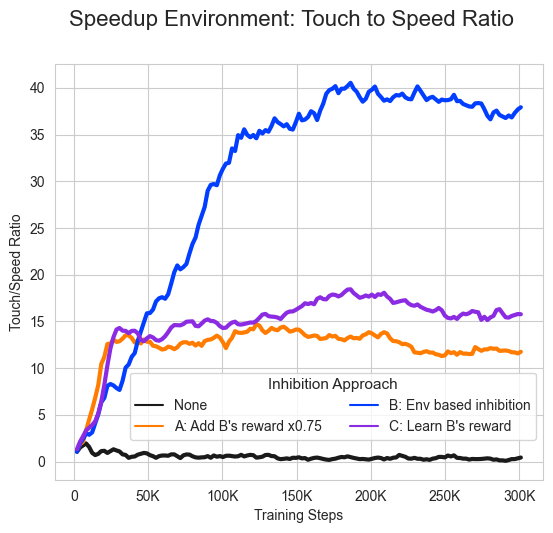

In [345]:
def plot_reward(df, title, columns, plot_titles=None, errorbars=None, move_legend=None, plt_loc=False, size_mult=0.7):
    if plot_titles is None:
        plot_titles = []
    if errorbars is None:
        errorbars = [None] * len(columns)
    elif isinstance(errorbars, bool):
        errorbars = ([('ci', 95)] if errorbars else [None]) * len(columns)
    else:
        assert len(errorbars) == len(columns)
        errorbars = [('ci', 95) if e else None for e in errorbars]

    assert len(columns) == len(plot_titles) or len(plot_titles) == 0
    hue = df.run.apply(run_to_inhibition_approach)

    hue_order = ["None"] + sorted(set(hue) - {"None"}) if 'None' in hue.values else sorted(set(hue))

    if len(columns) == 1: figsize = (7 * size_mult, 6 * size_mult)
    elif len(columns) == 2: figsize = (16 * size_mult, 6 * size_mult)
    else: figsize = (16 * size_mult, 12 * size_mult)
    plt.figure(figsize=figsize) # x: 16 / 7, y: 6 / 12
    plt.suptitle(title, fontsize=16)

    subplot_pos = generate_positions(len(columns))

    for i, _col in enumerate(columns):
        # plt.subplot(1, len(columns), i + 1)
        plt.subplot(*subplot_pos[i])
        ax = sns.lineplot(
            data=df,
            x=Col.STEP,
            y=_col,
            hue=hue,
            hue_order=hue_order,
            palette=colour_map,
            errorbar=errorbars[i],
            linewidth=3,
        )
        ax.set_title(_col)
        ax.set(xlabel=col_to_name(Col.STEP), ylabel=col_to_name(_col))
        ax.get_legend().remove()

        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda n, _: format_util.human_num(n)))

        if len(plot_titles) > 0:
            plt.title(plot_titles[i])

    max_lines, max_labels = [], []
    for axis in plt.gcf().axes:
        lines, labels = axis.get_legend_handles_labels()
        if len(labels) > len(max_labels):
            max_lines, max_labels = lines, labels

    # plt.legend(max_lines, max_labels, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    legend_subplot = 1
    kwloc = {'loc': 'lower right'} if plt_loc else {}

    leg = plt.legend(max_lines, max_labels, ncol=2, **kwloc)#, loc=loc, bbox_to_anchor=(legend_subplot-1, 0))
    leg.set_title('Inhibition Approach', prop={'size': 11})
    if move_legend is not None:
        x_offset, y_offset = move_legend
        bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())
        bb.x0 += x_offset
        bb.x1 += x_offset
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform = plt.gca().transAxes)

# plot_reward(df_mutex, "DoorMutex Environment: Rewards", [Col.A_REWARD, Col.B_REWARD], ["A's Reward", "B's Reward"], [True, True])
# plot_reward(df_mutex, "DoorMutex Environment: Steps to Open Door", [Col.DOOR_OPEN_STEP], [""], [True])
# plot_reward(df_shared, "DoorShared Environment: Rewards and Door Opening", [Col.B_REWARD, Col.DOOR_OPEN_STEP, Col.A_REWARD], ["B's Reward", "Steps to Open Door", "A's Reward"], True, move_legend=(0, 0.1))
# plot_reward(df_speedup, "Speedup Environment: Reward and Touches", [Col.B_REWARD, Col.TOUCHES], ["B's Reward", "Touch Count"], True, move_legend=(-1.1, -0.7), size_mult=0.9)
# plot_reward(df_speedup, "Speedup Environment: Touch Count and Speed", [Col.TOUCHES, Col.B_SPEED], ["Touch Count", "B's Speed"], False, size_mult=0.9, move_legend=(-0.5, -.35))
# plot_reward(df_slowdown, "Slowdown Environment: All Metrics", [Col.A_REWARD, Col.B_REWARD, Col.B_SPEED, Col.TOUCHES], ["A's Reward", "B's Reward", "B's Speed", "Touch Count"], [False, False, True, True], size_mult=0.9, move_legend=(-1.2, 0.55))
# plot_reward(df_speedup, "Speedup Environment: Touch to Speed Ratio", ['touch_speed_ratio'], [""], False, size_mult=0.9, plt_loc=True, move_legend=(0, 0.08))

In [350]:
# extract only the last step
max_step = df_all[Col.STEP].max()

dfl_mutex = df_mutex[df_mutex[Col.STEP] == max_step]
dfl_shared = df_shared[df_shared[Col.STEP] == max_step]
dfl_speedup = df_speedup[df_speedup[Col.STEP] == max_step]
dfl_slowdown = df_slowdown[df_slowdown[Col.STEP] == max_step]

In [352]:
def extract_stats(df, cols, extra=None):
    if extra is None:
        extra = []
    if isinstance(cols, str):
        cols = [cols]
    aggr_rule = {c: ['mean'] + extra for c in cols}
    df_stats = df.groupby(Col.INHIB).agg(aggr_rule)

    # flatten the column names
    df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]
    return df_stats

# print(extract_stats(dfl_mutex, [Col.A_REWARD, Col.B_REWARD]).style.to_latex())

# extract_stats(dfl_mutex, [Col.A_REWARD, Col.B_REWARD], extra=['std'])

# for df in [dfl_mutex, dfl_shared, dfl_speedup, dfl_slowdown]:
#     print(df.run.unique()[0])
#     print(extract_stats(df, [Col.A_REWARD, Col.B_REWARD]).to_csv())

# for df in [dfl_mutex, dfl_shared]:
#     print(df.run.unique()[0])
#     print(extract_stats(df, [Col.DOOR_OPEN_STEP], extra=['std']).to_csv())

for df in [dfl_speedup, dfl_slowdown]:
    print(df.run.unique()[0])
    print(extract_stats(df, [Col.TOUCHES, Col.B_SPEED, Col.TOUCH_SPEED_RATIO], extra=['std']).to_csv(float_format='%.2f'))


a_ppo_speedup_mutex_env-inhib-40_300K_5B57YZNJ_1
inhibition_approach,touches mean,touches std,b_speed mean,b_speed std,touch_speed_ratio mean,touch_speed_ratio std
add_b_rew_0.75,5.92,2.93,0.46,0.15,11.75,5.39
env_inhib,20.95,18.24,0.36,0.26,37.92,32.08
learn_b_reward,6.29,2.68,0.42,0.13,15.77,5.75
none,0.03,0.02,0.06,0.00,0.43,0.38

a_ppo_slowdown_mutex_env-inhib_300K_06Q6EHSS_1
inhibition_approach,touches mean,touches std,b_speed mean,b_speed std,touch_speed_ratio mean,touch_speed_ratio std
add_b_rew_0.25,3.15,1.35,0.73,0.08,4.53,2.23
env_inhib,1.35,0.74,0.80,0.08,1.79,1.11
learn_b_reward,2.78,1.30,0.75,0.08,3.86,2.27
none,4.61,1.09,0.73,0.08,6.42,1.77



In [49]:
print(df_speedup['inhibition_approach'].unique())

['env_inhib_35' 'env_inhib_40' 'add_b_rew_0.25' 'add_b_rew_0.75'
 'learn_b_reward' 'none']


In [90]:
pd.concat([df_speedup.run.apply(run_to_inhibition_approach), df_speedup.run.apply(lambda x: x)], axis=1).drop_duplicates()

,run,run
19327,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_1IIX0BRO_1
19474,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_2IFZ2O11_1
19621,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_7RCESMGN_1
19768,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_K3L6CJ6R_1
19786,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_TF8UF46V_1
19827,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_TTUUEUK1_1
19974,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_TW0S1CO5_1
20121,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_UJWIG1ZK_1
20268,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_WVBK4GU5_1
20415,B: Env based inhibition (+35),a_ppo_speedup_mutex_env-inhib-35_300K_ZP94RPAH_1
